**Digit recognization model** 
This model will be trained on the MNIST handwritten digits dataset (This notebook uses the CNN method)
* tensorflow is our general purpose ml library with all the utlities we need
* numpy has all our various data types like arrays, matrices etc.
* matplotlib for plotting and visualising the numpy array of values

In [49]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

**Library diagnostic information**

In [50]:
print('Numpy ' + np.__version__)
print('Tensorflow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)

Numpy 1.20.0
Tensorflow 2.6.2
Keras 2.6.0


**Model Parameters**

In [51]:
tflite_model_name = 'digit_recognize_28'

**Load the dataset from tensorflow datasets**

* X is the list of input image array (input data is uint8)
* Y list of the digit the input image corresponds to (digits 0 - 9)

the data is already pre divided into train and test datasets

In [52]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

In [53]:
print('Number of total samples: ', len(X_train) + len(X_test))
print('Number of train samples: ', len(X_train))
print('Number of test samples: ', len(X_test))

Number of total samples:  70000
Number of train samples:  60000
Number of test samples:  10000


**Show the shape of the input image**

In [54]:
X_train[0].shape

(28, 28)

**Visualize a sample and the corresponding digit from the samples**

This digit is:  5


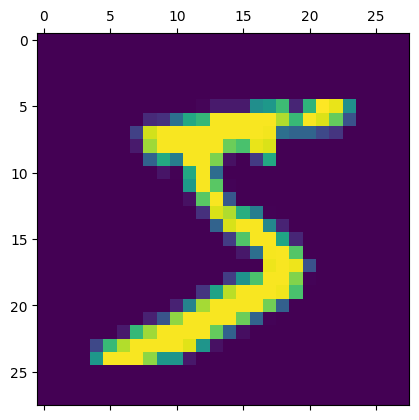

In [55]:
plt.matshow(X_train[0])
print('This digit is: ', Y_train[0])

**convert to float**
This model performs better when utilizing floating point computations, 
quantized model lead to a plateau in overall accuracy 

In [56]:
X_train = X_train/255
X_test = X_test/255

**reshape the training data from 2D (28, 28) into flat 1D (784)**

In [57]:
X_train = tf.expand_dims(X_train, axis=-1)

X_test = tf.expand_dims(X_test, axis=-1)

**Create the skeleton for the neural network model and configure the optimizer, and metrics**

In [58]:
model = keras.Sequential([
    keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                8010      
Total params: 17,578
Trainable params: 17,578
Non-trainable params: 0
__________________________________________________

**Train the model**

In [59]:
with tf.device('/GPU:0'):
    history = model.fit(
                    X_train,
                    Y_train,
                    epochs=5,
                    batch_size=100
    )


Epoch 1/5
600/600 [==============================] - 2s 2ms/step - loss: 0.2973 - accuracy: 0.9143
Epoch 2/5
600/600 [==============================] - 1s 2ms/step - loss: 0.0824 - accuracy: 0.9752
Epoch 3/5
600/600 [==============================] - 1s 2ms/step - loss: 0.0602 - accuracy: 0.9820
Epoch 4/5
600/600 [==============================] - 1s 2ms/step - loss: 0.0501 - accuracy: 0.9844
Epoch 5/5
600/600 [==============================] - 1s 2ms/step - loss: 0.0433 - accuracy: 0.9872


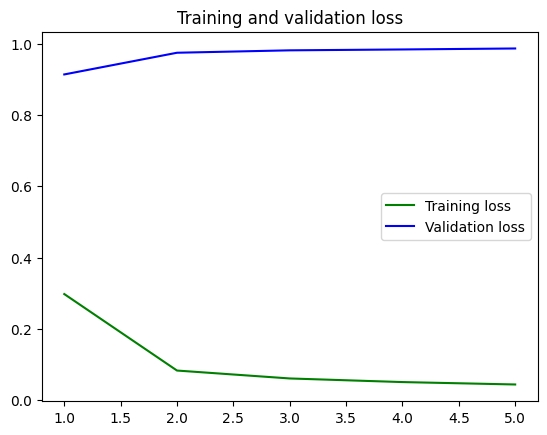

In [60]:
loss = history.history['loss']
val_loss = history.history['accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**collect a list of all the incorrect predictions**

In [61]:
predictions = model.predict(X_test)

idx = []

for i in range(len(Y_test)):
    if(Y_test[i] != np.argmax((predictions[i]))):
        idx.append(i)

# print the percent of correct predictions
print('test score: {}'.format(1 - (len(idx)/len(Y_test))))

test score: 0.9866


**Visualize one of the random errors made**

(28, 28)
Actual: 9, Predicted: 0


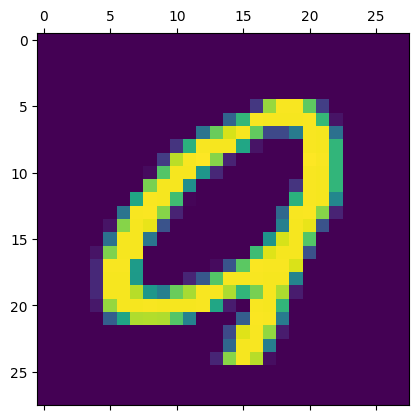

In [62]:
random_error = random.choice(idx)

print(X_test[random_error][:,:,0].shape)

plt.matshow(X_test[random_error][:,:,0])
print('Actual: {}, Predicted: {}'.format(Y_test[random_error], np.argmax((predictions[random_error]))))

**Convert and optimize it as a tflite model**

In [63]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
#converter.optimizations = [tf.lite.Optimize.DEFAULT] (removed because it generates mismatching data types)
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpt26niiky/assets


INFO:tensorflow:Assets written to: /tmp/tmpt26niiky/assets
2023-09-22 17:21:19.785809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-22 17:21:19.785939: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-09-22 17:21:19.786037: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-09-22 17:21:19.786402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-22 17:21:19.786477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-22 17:21:19.786529: I t

72892

Make a model with FP16

In [64]:
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

open(tflite_model_name + '_fp16' + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpypb_h3mk/assets


INFO:tensorflow:Assets written to: /tmp/tmpypb_h3mk/assets
2023-09-22 17:21:20.141055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-22 17:21:20.141282: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-09-22 17:21:20.141420: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-09-22 17:21:20.141673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-22 17:21:20.141752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-22 17:21:20.141806: I t

72892